<a href="https://colab.research.google.com/github/rhausman/brain_tumor_analysis/blob/main/Tumor_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
!pip install torchtest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split 

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch._C import NoneType
from torchtest import assert_vars_change

import os
from math import sqrt
import time
from copy import deepcopy
import skimage 
from skimage import io
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
import plotly.express as px
import plotly.figure_factory as ff
from matplotlib import pyplot as plt 

from PIL import Image
from IPython.display import clear_output
# set seed for reproducability
torch.manual_seed(42)

## Get the data

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
%cd /content/drive/MyDrive/kaggle/
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection --unzip
""" MORE DATA OPTIONS:
!kaggle competitions download -c hpa-single-cell-image-classification # whole cell image thing

!kaggle datasets download -d dschettler8845/human-protein-atlas-yellow-cell-tile-dataset
"""

/content/drive/MyDrive/kaggle
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


' MORE DATA OPTIONS:\n!kaggle competitions download -c hpa-single-cell-image-classification # whole cell image thing\n\n!kaggle datasets download -d dschettler8845/human-protein-atlas-yellow-cell-tile-dataset\n'

In [5]:
os.listdir()

['kaggle.json',
 'human-protein-atlas-yellow-cell-tile-dataset.zip',
 'brain_tumor_dataset',
 'no',
 'yes',
 'brain-mri-images-for-brain-tumor-detection.zip',
 '1676335239.pt',
 '1676336668.pt',
 '1676337773.pt',
 '1676339293.pt',
 '1676341225.pt',
 '1676341575.pt',
 '1676342570.pt',
 '1676343146.pt',
 '1676354204.pt',
 '1677558439.pt',
 '1677600789.pt',
 '1677601472.pt',
 '1677603110.pt',
 '1677611569.pt',
 '1677613092.pt',
 '1677614061.pt',
 '1677614140.pt',
 '1677614743.pt',
 '1677614811.pt',
 '1677615045.pt',
 '1677615995.pt',
 '1677616546.pt',
 '1678047583_ae.pt',
 '1678048679_ae.pt',
 '1678049426_cls.pt',
 '1678049683_cls.pt']

## Notes
* Remove InvertColor transforms
* Try using PCA to visualize the latent space. See if it separates the classes.

\## Set up Dataset

Notes:
* Using a `RandomInvert()` transform is not intuitive because color-inverted images don't appear in the train or validation set, but it's desireable because: 1. Emperically, it SIGNIFICANTLY reduced overfitting in my case, and 2. It's possible that some computer systems that process brain scans could invert the color, and concievably a system using my model could recieve a color-inverted image.

In [6]:
DEFAULT_RES = 200
class MyDataSet(Dataset):
  def __init__(self, pos_dir: str, neg_dir: str, transform=None, res:int=DEFAULT_RES):
    self.res = res
    self.pos_dir = pos_dir
    self.neg_dir = neg_dir
    self.transform = transform
    self.pos_filenames = [ os.path.join(pos_dir, x) for x in os.listdir(pos_dir)]
    self.neg_filenames = [ os.path.join(neg_dir, x) for x in os.listdir(neg_dir)]

    if not self.transform: # kind of need one. 
      self.transform_list = [
          transforms.Resize([res, res]), # maybe should make this bigger
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          #transforms.RandomRotation(15),
          #transforms.RandomInvert(),
          transforms.ToTensor(),
          #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ]
      self.transform = transforms.Compose(self.transform_list)
  
  def get_mean_and_std(self):
    loader = DataLoader(self, batch_size=10, num_workers=1, shuffle=False)
    mean = 0.
    std = 0.
    nb_samples = 0.
    for _data in loader:
        data = _data[0]
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean, std
  
  def set_up_normalization(self, mean, std):
    self.transform_list.append(transforms.Normalize(mean=(mean), std=(std) ))
    self.transform = transforms.Compose(self.transform_list)
    print("Normalization added to transform")
    

  def __len__(self):
    return len(self.pos_filenames) + len(self.neg_filenames)

  def __getitem__(self, x):
    #print("Index: ", x)
    img = None
    tumor = None
    if x < len(self.neg_filenames): # return a negative
      img = self.get_single_image(self.neg_filenames[x])
      tumor = 0
    else: # return a positive
      img = self.get_single_image(self.pos_filenames[x%len(self.neg_filenames)])
      tumor = 1
    img = img.convert('L')
    if self.transform:
      #print("transforming. shape before", img.size)
      img = self.transform(img)
      #print("shape after", img.size)
    if img is None:
      print("Problem: ", x%len(self.neg_filenames), self.pos_filenames[x%len(self.neg_filenames)])
    #print(img.size())
    return img, tumor

  # filename should be absolute path
  def get_single_image(self, filename):
    img = Image.open(filename)#io.imread(filename)
    if img is None:
      print("YO: ", filename)
    return img

## View Samples to see if it's working

Normalization added to transform
torch.Size([1, 200, 200])


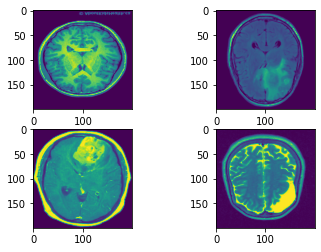

In [7]:
def show_batch(batch):
  batch = batch[0]
  f, axarr = plt.subplots(2,2)
  print(batch[0].size())
  batch = [ np.squeeze(t.numpy(), axis=0) for t in batch ]
  axarr[0][0].imshow(batch[0])
  axarr[0][1].imshow(batch[1])
  axarr[1][0].imshow(batch[2])
  axarr[1][1].imshow(batch[3])
  #print(batch, type(batch))

ds = MyDataSet(pos_dir = "/content/drive/MyDrive/kaggle/brain_tumor_dataset/yes", neg_dir="/content/drive/MyDrive/kaggle/brain_tumor_dataset/no")
mean, std = ds.get_mean_and_std() # set up normalization with the same mean and td overall for each
ds.set_up_normalization(mean, std)
dl = DataLoader(ds, batch_size=4, shuffle=True, num_workers=0) # for now no extra workers

for i, batch in enumerate(dl):
  if i ==4:
    show_batch(batch)
    break

# Classifier

## Model Definition - Classifier
* Idea: VAE with one disentangled latent variable for tumor_presence (0 for no tumor, 1 for tumor)
* This way it's both a predictor and example generator. 
1. to predict: embed an image and look at the latent variable value
2. To generate: generate from point in latent space, control the latent variable as desired.
* base on: https://ieeexplore.ieee.org/document/9291992 or another paper

In [8]:
# first I'll do a classifier
class Classifier(nn.Module):
  def __init__(self, res:int =DEFAULT_RES, confidence=0.75):
    super(Classifier, self).__init__()
    self.res = res
    self.confidence = confidence
    self.layers = []
    s = (1, self.res, self.res)

    self.layers.append(nn.Conv2d(1, 4, 5))
    s = 4, s[1] - 4, s[2]-4 # stride is 2 i believe
    self.layers.append(nn.MaxPool2d((2,2)))
    s = s[0], s[1]/2, s[2]/2
    self.layers.append(nn.Conv2d(4, 8, 10))
    s = 8, s[1]-9, s[2] - 9
    self.layers.append(nn.MaxPool2d(2))
    s = s[0], (s[1]-1)/2, (s[2]-1)/2
    self.layers.append(nn.Flatten())
    s = s[0]*s[1]*s[2], None
    self.layers.append(nn.Linear( int(s[0]), 120))
    #self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(120, 60) )
    #self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(60,20))
    #self.layers.append(nn.ReLU())
    self.layers.append(nn.Linear(20, 1))
    self.layers.append(nn.Sigmoid())
    #self.layers = [self.conv1, self.pool1, self.conv2, self.pool2, self.flatten, self.l1, self.l2, self.l3, self.l4, self.sigmoid]
    # dropout?
    self.seq = nn.Sequential(*self.layers)

  def forward(self, x):
    #print("input shape: ", x.shape)
    #for i, layer in enumerate(self.layers):
    #  x = layer(x) #F.relu(layer(x))
      #print(f"{i} shape: {x.shape}")
    x = self.seq(x)
    return x # get in batch format
  
  def inference(self, x):
    out = self.forward(x)
    out = out > self.confidence
    return out

## Training

In [9]:
# constants
epochs = 40

# data
ds = MyDataSet(pos_dir = "/content/drive/MyDrive/kaggle/brain_tumor_dataset/yes", neg_dir="/content/drive/MyDrive/kaggle/brain_tumor_dataset/no")
mean, std = ds.get_mean_and_std() # set up normalization with the same mean and td overall for each
ds.set_up_normalization(mean, std)
train_set, test_set = random_split(ds, [0.8, 0.2], generator=torch.Generator().manual_seed(42)) # manual seed for reproducible result right now

print(f"Train set: {len(train_set)}, Test set: {len(test_set)}")
train_loader = DataLoader(train_set, batch_size=12, shuffle=True, num_workers=2) # for now no extra workers
test_loader = DataLoader(test_set, batch_size=12, shuffle = False, num_workers=2)

# save info
model_save_name = str(int(time.time())) + "_cls.pt" # unique name
save_path = f"/content/drive/MyDrive/kaggle/{model_save_name}"
print("Training model at ", model_save_name)

Normalization added to transform
Train set: 203, Test set: 50
Training model at  1678053259_cls.pt


Epoch 30 train loss: 1.9447893886826932
 test loss: 3.1381235273547645


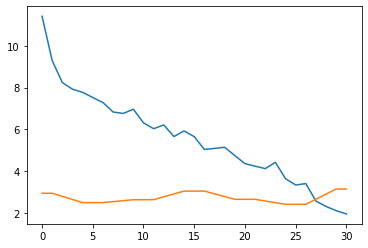

KeyboardInterrupt: ignored

In [68]:
net = Classifier()
loss_fxn = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-7) # todo try adding l2 regularization with: weight_decay=1e-5

train_losses = []
test_losses = []
for epoch in range(epochs):

  running_loss = 0.
  for i, batch in enumerate(train_loader):
    X, y = batch
    optimizer.zero_grad()
    output = net(X)
    output = torch.squeeze(output, 1)
    loss = loss_fxn(output, y.float())
    loss.backward() # retain_graph=True for multi losses?
    optimizer.step()

    #print(f"Output: {output}, labels: {y}, loss: {loss.item()}")
    #stats
    running_loss += loss.item()
  # save model each epoch
  torch.save(net.state_dict(), save_path)
  train_losses.append(running_loss)
  # see the validation loss
  if epoch % 5 == 0:
    net.eval()
    with torch.no_grad():
      test_loss = 0.
      for i, batch in enumerate(test_loader):
        X, y = batch 
        output = net(X)
        output = torch.squeeze(output, 1)
        loss = loss_fxn(output, y.float())
        test_loss += loss.item()
      if len(test_losses) > 0:
        fill_losses = np.linspace(test_losses[-1], test_loss, 4)
        test_losses.extend(list(fill_losses))
      test_losses.append(test_loss)
    net.train()
    
  # Display output!
  clear_output(wait=True)
  print(f"Epoch {epoch} train loss: {train_losses[-1]}\n test loss: {test_losses[-1]}")
  plt.plot(train_losses)
  plt.plot(test_losses)
  plt.show()


## Validation 
* Validate on train and validation data to see if the issue is overfitting or mere underperformance/underfitting

Good models so far:
* 1676343146.pt
* 1676354204.pt (fantastic. 40 epochs. I recently discoverd bug in training code)
* 1677601472.pt (good performance, but somewhat overfit. Inversion was not used for this model)
* 1677603110.pt (This didn't do so great, though inversion was used)

In [10]:
desired_model_name = None #'1676354204.pt'
desired_model_path = os.path.join("/content/drive/MyDrive/kaggle", sorted([ x for x in os.listdir() if "_cls.pt" in x ])[-1] if desired_model_name is None else desired_model_name)
print('Selected model for evaluation: ', desired_model_path)

Selected model for evaluation:  /content/drive/MyDrive/kaggle/1678049683_cls.pt


In [47]:
net = Classifier()
net.load_state_dict(torch.load(desired_model_path))
net.confidence = 0.5
net.eval()

def evaluate(model, loader):
  all_preds = []
  all_labels = []
  for i, batch in enumerate(loader):
    X, y = batch
    out = model(X)
    all_preds += list(out.detach().squeeze(1).numpy())
    all_labels += list(y.numpy())
  
  
  all_preds_binary = np.array(all_preds) > net.confidence
  all_labels = np.array(all_labels)
  f_neg, f_pos, t_neg, t_pos = (np.logical_and(all_preds_binary==0, all_labels==1).sum(), 
                              np.logical_and(all_preds_binary==1, all_labels==0).sum(), 
                              np.logical_and(all_preds_binary==0, all_labels==0).sum(), 
                              np.logical_and(all_preds_binary==1, all_labels==1).sum()
                              )
  n = float(len(all_labels))
  print(f"False negatives: {f_neg} ({100*f_neg/n}% of total)")
  print(f"False positives: {f_pos} ({100*f_pos/n}% of total)")
  print(f"True negatives:  {t_neg} ({100*t_neg/n}% of total)")
  print(f"True positives:  {t_pos} ({100*t_pos/n}% of total)")

  # ROC curve
  #breakpoint()
  #breakpoint()
  binary_converter = LabelBinarizer().fit( list(all_labels) + [2])
  y_onehot = binary_converter.transform( np.array(list(all_labels)))
  y_score = all_preds
  pos_class = "Tumor present"
  class_id = 1 #np.flatnonzero(binary_converter.classes_ == pos_class)[0]
  RocCurveDisplay.from_predictions(
    y_onehot[:, class_id],
    np.array(y_score),
    name= pos_class,
    color="darkorange",
  )
  plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve for Tumor Detection")
  plt.legend()
  plt.show()

  # confusion matrix. Vertical axis is label, horizontal is prediction
  z = [[t_neg, f_pos], [f_neg, t_pos]]
  z_text = [[str(val) for val in row] for row in z]
  axis_labels = ["No Tumor", "Tumor"]
  fig = px.imshow(z, text_auto=True, title="Confusion Matrix", ) #ff.create_annotated_heatmap(z, x=axis_labels, y=axis_labels, annotation_text = z_text)
  #fig.update_layout(title_text='<b>Confusion Matrix</b>', )
  fig.update_xaxes(title="Prediction")
  fig.update_yaxes(title="Actual Value")
  fig.show()


False negatives: 5 (10.0% of total)
False positives: 5 (10.0% of total)
True negatives:  11 (22.0% of total)
True positives:  29 (58.0% of total)


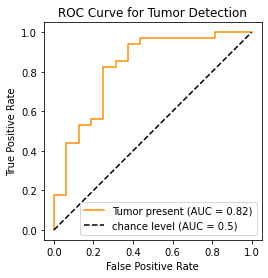

In [48]:
evaluate(net, test_loader)

False negatives: 1 (0.49261083743842365% of total)
False positives: 0 (0.0% of total)
True negatives:  82 (40.39408866995074% of total)
True positives:  120 (59.11330049261084% of total)


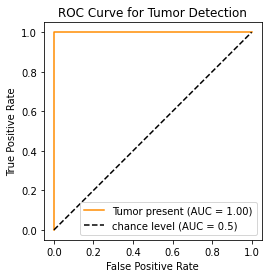

In [49]:
evaluate(net, train_loader)

## Analysis

* The simple classifier model obtains decent classification results, with validation set AUC = 0.82
* There is a little bit of overfitting happening, as evidenced by the higher score on the train set compared to the test set. This can be mitigated by using dropout or more weight decay on the optimizer. 
* In this scenario, I am reluctant to use dropout because the size of my dataset is very limited.

# AutoEncoder

## AutoEncoder Model
* Create a model that can reconstruct based on point in latent space
* Disentangle a dimension of the latent space for tumor presence
* Try to disentangle other dimensions in an unsupervised way

In [30]:
# first I'll do a classifier
class VAE(nn.Module):
  def __init__(self, res:int =DEFAULT_RES, confidence=0.75):
    super(VAE, self).__init__()
    self.res = res
    self.reshape = 1, 4, 8 # channels for managing conv layers
    self.confidence = confidence
    self.encoder_conv, self.encoder_linear = [], []
    self.decoder_linear, self.decoder_conv = [], []

    s = (1, self.res, self.res)

    self.encoder_conv.append(nn.Conv2d(1, 4, 5))
    s = 4, s[1] - 4, s[2]-4 # stride is 2 i believe
    self.encoder_conv.append(nn.MaxPool2d((2,2)))
    s = s[0], s[1]/2, s[2]/2
    self.encoder_conv.append(nn.Conv2d(4, 8, 10))
    s = 8, s[1]-9, s[2] - 9
    self.encoder_conv.append(nn.MaxPool2d(2))
    s = s[0], (s[1]-1)/2, (s[2]-1)/2
    self.flatten = nn.Flatten()
    s = s[0]*s[1]*s[2], None
    self.encoder_linear.append(nn.Linear( int(s[0]), 120))
    self.encoder_linear.append(nn.Linear(120, 60) )
    
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(8,44,44))

    self.encoder_conv = nn.Sequential(*self.encoder_conv)
    self.encoder_linear = nn.Sequential(*self.encoder_linear)

    def app(l):
      self.decoder_linear.append(l)
    app(nn.Linear(60,120))
    app(nn.Linear(120, int(s[0])) )
    self.decoder_linear = nn.Sequential(*self.decoder_linear)

    def app(l):
      self.decoder_conv.append(l)
    #app(nn.Upsample(size=(121,121))) #scale_factor=1.1)) #size=() ))
    app(nn.ConvTranspose2d(8, 4, 10, padding=2, output_padding=1, stride=2))
    app(nn.Upsample(size=(100, 100)))
    app(nn.ConvTranspose2d(4,1, 5, padding=2, output_padding=1, stride=2))
    """
    app(nn.ConvTranspose2d(8, 6, 10))
    app(nn.ConvTranspose2d(6, 4,  8))
    app(nn.ConvTranspose2d(4, 1,  8)) #padding=2, output_padding=1, stride=2))
    app(nn.ConvTranspose2d(1, 1,  5, padding=2, output_padding=1, stride=2))
    """
    self.decoder_conv = nn.Sequential(*self.decoder_conv)
    # todo: add batch norm!
    # todo add ReLU or sigmoid, or without it.
    # need to de-normalize output to visualize
    #self.layers = [self.conv1, self.pool1, self.conv2, self.pool2, self.flatten, self.l1, self.l2, self.l3, self.l4, self.sigmoid]
    # dropout?
    # self.seq = nn.Sequential(*self.layers)

  def forward(self, x):
    latent = self.encode(x)
    #reconstruction = self.decode(x)
    reconstruction = self.decode(latent)
    return torch.sigmoid(reconstruction) # activation fxn. Keep in mind we'll have to transform since input was normalized, gotta transform output to compensate
  
  def encode(self, x):
    x = self.encoder_conv(x)
    #print(f"Shape after conv: {x.shape}")
    x = self.flatten(x)
    #print(f"Shape after flattening: {x.shape}")
    return self.encoder_linear(x)
  
  def decode(self, x):
    #x = torch.relu(self.decoder[0](x))
    #x = torch.relu(self.decoder[1](x))
    x = self.decoder_linear(x)
    #x = x.view(x.shape[0], 8, 44, 44) # reshape
    x = self.unflatten(x)
    x = torch.relu(self.decoder_conv(x))
    #print("x shape: ", x.shape)
    # todo decode linear
    # todo activation?
    return x

  def inference(self, x, mean=0, std=1):
    out = self.forward(x)
    #return out.mul(std).add(mean)
    return out

## Train Autoencoder

In [31]:
# helper fxns
def show_batch(batch, n=None):
  if n is not None:
    batch = batch[:n]
  sidelen = int(sqrt(len(batch)))+1
  f, axarr = plt.subplots(sidelen,sidelen)
  #print(batch[0].size())
  batch = [ np.squeeze(t.detach().numpy() , axis=0) if 1 in t.shape else t.detach().numpy() for t in batch ]
  for i in range(sidelen):
    for j in range(sidelen):
      index = (sidelen*i)+j
      if index >= len(batch):
        break
      axarr[i][j].imshow(batch[index])

In [32]:
# constants
epochs = 100

# data
ds = MyDataSet(pos_dir = "/content/drive/MyDrive/kaggle/brain_tumor_dataset/yes", neg_dir="/content/drive/MyDrive/kaggle/brain_tumor_dataset/no")
mean, std = ds.get_mean_and_std() # set up normalization with the same mean and td overall for each
ds.set_up_normalization(mean, std)
train_set, test_set = random_split(ds, [0.8, 0.2], generator=torch.Generator().manual_seed(42)) # manual seed for reproducible result right now

print(f"Train set: {len(train_set)}, Test set: {len(test_set)}")
train_loader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=2) # for now no extra workers
test_loader = DataLoader(test_set, batch_size=10, shuffle = False, num_workers=0)

# save info
model_save_name = str(int(time.time())) + "_ae.pt" # unique name
save_path = f"/content/drive/MyDrive/kaggle/{model_save_name}"
print("Training model at ", model_save_name)

Normalization added to transform
Train set: 203, Test set: 50
Training model at  1678048679_ae.pt


In [33]:
net = VAE()
one_batch = next(iter(train_loader))[0]
assert_vars_change(model=net,
    loss_fn=nn.MSELoss(),
    optim=torch.optim.Adam(net.parameters()),
    batch=one_batch,
    device = 'cpu')

RuntimeError: ignored

Epoch 45 train loss: 1.4258264303207397
 test loss: 1.425825595855713


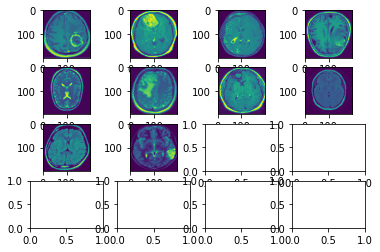

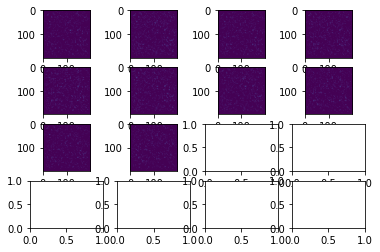

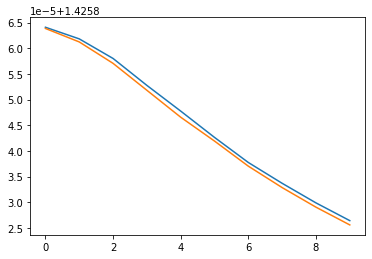

KeyboardInterrupt: ignored

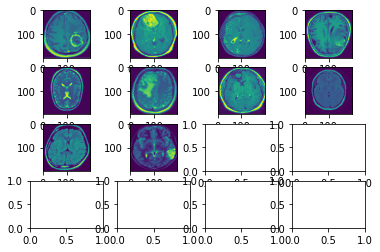

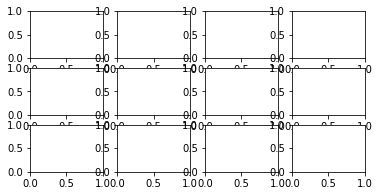

In [34]:
net = VAE()
loss_fxn = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # weight_decay = 1e-5

train_losses = []
test_losses = []

one_batch = next(iter(train_loader))

for epoch in range(epochs):
  net.train()
  running_loss = 0.
  for i, batch in enumerate([one_batch]): #enumerate(train_loader):
    X, y = batch
    optimizer.zero_grad()
    output = net(X)
    output = torch.squeeze(output, 1)
    loss = loss_fxn(output, torch.squeeze(X))
    loss.backward() # retain_graph=True for multi losses?
    optimizer.step()

    running_loss += loss.item()
    """"""
    break # todo remove

    #print(f"Output: {output}, labels: {y}, loss: {loss.item()}")
    #stats
  """ TODO REMOVE """
  if epoch % 5 != 0: # gotta remove these lines
    continue 

  # save model each epoch
  torch.save(net.state_dict(), save_path)
  train_losses.append(running_loss)
  # see the validation loss
  net.eval()
  with torch.no_grad():
    test_loss = 0.
    for i, val_batch in enumerate([one_batch]): #enumerate(test_loader): # todo CHANGE THIS BACK
      X, y = val_batch 
      output = net(X)
      output = torch.squeeze(output, 1)
      loss = loss_fxn(output, torch.squeeze(X))
      test_loss += loss.item()
    test_losses.append(test_loss)
    """"""
    #show_batch(X)
    #show_batch(net.inference(X))
    show_batch(batch[0]) # TODO REMOVE THESE 2 LINES
    show_batch(net.inference(batch[0]))
    
  # Display output!
  clear_output(wait=True)
  print(f"Epoch {epoch} train loss: {train_losses[-1]}\n test loss: {test_losses[-1]}")
  fig, ax = plt.subplots()
  ax.plot(train_losses)
  ax.plot(test_losses)
  plt.show()


### Check for vanishing gradients

In [51]:
#net = VAE()
for name, param in net.named_parameters():
  if "weight" in name:
    print(f"Name: {name}, mean: {param.mean()}, std: {param.std()}")

Name: encoder_conv.0.weight, mean: -0.007121846545487642, std: 0.11122100055217743
Name: encoder_conv.2.weight, mean: 0.0006974564748816192, std: 0.02904246747493744
Name: encoder_linear.0.weight, mean: -2.0403147615866146e-08, std: 0.00463792635127902
Name: encoder_linear.1.weight, mean: -0.00018398139218334109, std: 0.05261940509080887
Name: decoder_linear.0.weight, mean: -0.000797932269051671, std: 0.07415377348661423
Name: decoder_linear.1.weight, mean: -3.500385719235055e-05, std: 0.05269685387611389
Name: decoder_conv.0.weight, mean: 9.979640890378505e-05, std: 0.02864549309015274
Name: decoder_conv.2.weight, mean: 0.007021212950348854, std: 0.11655139178037643


## Visualize AE outputs

In [ ]:
output[0].min()

tensor(0.5000)

In [ ]:
desired_model_name = None
desired_model_path = os.path.join("/content/drive/MyDrive/kaggle", sorted([ x for x in os.listdir('/content/drive/MyDrive/kaggle') if len(x)>3 and "_ae.pt" in x ])[-1] if desired_model_name is None else desired_model_name)
print('Selected model for evaluation: ', desired_model_path)

Selected model for evaluation:  /content/drive/MyDrive/kaggle/1677616546.pt


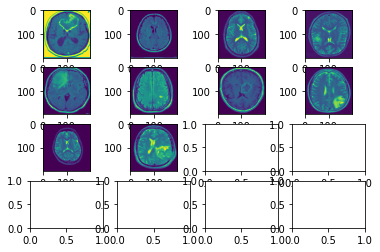

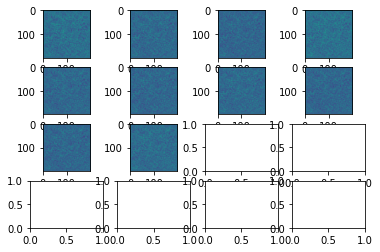

In [ ]:
net = VAE()
net.load_state_dict(torch.load(desired_model_path))
net.eval()

for i, batch in enumerate(test_loader):
  if i != 0:
    break 
  X, y = batch
  reconstruction = net.inference(X)
  # show orig
  # show reconstruction
show_batch(X)
show_batch(reconstruction)

In [ ]:
reconstruction.requires_grad

True

## Validate Quantitatively

In [ ]:
net = Classifier()
net.load_state_dict(torch.load(desired_model_path))
net.confidence = 0.75
net.eval()

def evaluate(model, loader):
  all_preds = []
  all_labels = []
  for i, batch in enumerate(loader):
    X, y = batch
    out = model.inference(X)
    all_preds += list(out.detach().squeeze(1).numpy())
    all_labels += list(y.numpy())
  all_preds = np.array(all_preds)
  all_labels = np.array(all_labels)
  f_neg, f_pos, t_neg, t_pos = (np.logical_and(all_preds==0, all_labels==1).sum(), 
                              np.logical_and(all_preds==1, all_labels==0).sum(), 
                              np.logical_and(all_preds==0, all_labels==0).sum(), 
                              np.logical_and(all_preds==1, all_labels==1).sum()
                              )
  n = float(len(all_labels))
  print(f"False negatives: {f_neg} ({100*f_neg/n}% of total)")
  print(f"False positives: {f_pos} ({100*f_pos/n}% of total)")
  print(f"True negatives:  {t_neg} ({100*t_neg/n}% of total)")
  print(f"True positives:  {t_pos} ({100*t_pos/n}% of total)")

## TODO:
* reduce kernel sizes to make simpler and lower training time/fewer parameters
* Try out simple AE, then VAE, then disentangle

In [ ]:
net = VAE()
X, y = next(iter(train_loader))
#latent = net.encode(X)
#print(f"Latent shape: {latent.shape}")
out = net(X)
out.shape

x shape:  torch.Size([10, 113288])
x shape:  torch.Size([10, 8, 119, 119])
x shape:  torch.Size([10, 1, 500, 500])


torch.Size([10, 1, 500, 500])

In [ ]:
len(ds)

253

## Idea
* What if I try characterizing the latent space. In word embeddings, there are concept vectors like gender. Vec_man - Vec_woman is parallel to Vec_king - Vec_king. What if I'm able to visualize the distribution in latent space (perhaps via dimensionality reduction) and get the "concept vector" of tumor, and perhaps some other features? 
* And then demonstrate generation based on variations of adding that feature to embeddings. So if v_tumor is = tumor_centroid - non_tumor_centroid in embedding space, do the following. 1. Embed a non-tumor image, 2. Add v_tumor to the embedding, 3. Decode and hopefully get a very similar image but with a tumor. Can also do the whole process in reverse, subtracting the v_tumor